# 1. Setup

## 1.1 Install Dependencies

In [3]:
!pip install tensorflow  opencv-python matplotlib


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import tensorflow as tf

## 1.2 Import Dependencies

In [4]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [93]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [6]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures

In [9]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [10]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [13]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf data/anchor/archive/lfw-funneled.tgz

In [ ]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

In [15]:
# Import uuid library to generate unique image names
import uuid

In [16]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\ea111753-09f8-11f0-ac38-60f26206a526.jpg'

In [19]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [28]:
import os
import glob

jpg_files = glob.glob(os.path.join(POS_PATH, '**', '*.jpg'), recursive=True)
print(len(jpg_files))


2380


# 2.x NEW - Data Augmentation

In [25]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [26]:
import os
import uuid

In [12]:
img_path = os.path.join(ANC_PATH, '924e839c-135f-11ec-b54e-a0cec8d2d278.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [27]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [29]:
for file_name in os.listdir(os.path.join(ANC_PATH)):
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [30]:
import os
import glob

jpg_files = glob.glob(os.path.join(ANC_PATH, '**', '*.jpg'), recursive=True)
print(len(jpg_files))


2500


# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [31]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(2000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(2000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(2000)

In [32]:
dir_test = anchor.as_numpy_iterator()

In [33]:
print(dir_test.next())

b'data\\anchor\\8c2aac89-09f9-11f0-aa40-60f26206a526.jpg'


## 3.2 Preprocessing - Scale and Resize

In [34]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [176]:
img = preprocess('data\\anchor\\a4e73462-135f-11ec-9e6e-a0cec8d2d278.jpg')

In [177]:
img.numpy().max() 

1.0

In [178]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

## 3.3 Create Labelled Dataset

In [179]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [40]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [52]:
positives = tf.data.Dataset.zip((
    anchor, 
    positive, 
    tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor), dtype=tf.float32)).map(lambda x: tf.cast(x, tf.float32))  # Ensure Python float-like behavior
))
negatives = tf.data.Dataset.zip((
    anchor, 
    negative, 
    tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor), dtype=tf.float32)).map(lambda x: tf.cast(x, tf.float32))  # Ensure Python float-like behavior
))
data = positives.concatenate(negatives)
  # Output: (b'path_to_anchor', b'path_to_positive', 1.0)


In [62]:
samples = data.as_numpy_iterator()

In [63]:
exampple = samples.next()

In [64]:
exampple

(b'data\\anchor\\6aa1db94-09fa-11f0-9f83-60f26206a526.jpg',
 b'data\\positive\\4052aab9-09fa-11f0-a163-60f26206a526.jpg',
 np.float32(1.0))

## 3.4 Build Train and Test Partition

In [65]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [66]:
res = preprocess_twin(*exampple)

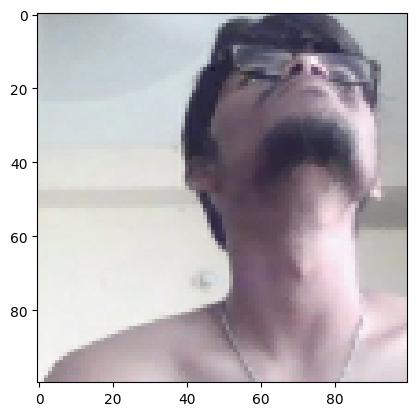

In [67]:
plt.imshow(res[1])

In [69]:
len(res)

3

In [70]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [71]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [72]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [79]:
inp = Input(shape=(100,100,3), name='input_image')

In [80]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [81]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [82]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [83]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [84]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [85]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [86]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [106]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [107]:
embedding = make_embedding()

In [108]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

## 4.2 Build Distance Layer

In [115]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [116]:
l1 = L1Dist()

In [117]:
l1

<L1Dist name=l1_dist_6, built=False>

In [123]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.models import Model

# Define the embedding model
def make_embedding(): 
    inp = Input(shape=(100, 100, 3))
    
    # CNN blocks
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D((2,2), padding='same')(c1)
    
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D((2,2), padding='same')(c2)
    
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D((2,2), padding='same')(c3)
    
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=inp, outputs=d1)

# Create the embedding model
embedding = make_embedding()

# Siamese L1 Distance class
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
       
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

# Instantiate L1 Distance layer
l1 = L1Dist()

# Create dummy images for testing
dummy_anchor = tf.random.normal((1, 100, 100, 3))  # Single image
dummy_validation = tf.random.normal((1, 100, 100, 3))  # Single image

# Pass images through the embedding model
anchor_embedding = embedding(dummy_anchor)
validation_embedding = embedding(dummy_validation)

# **Manually build the L1Dist layer**
l1.build((None, 4096))  # Specify expected input shape

# Compute L1 Distance
distance = l1(anchor_embedding, validation_embedding)
print(distance)  # Output: Tensor containing absolute difference


tf.Tensor([[0.00180167 0.0059486  0.00239223 ... 0.00626582 0.01265115 0.01375383]], shape=(1, 4096), dtype=float32)


## 4.3 Make Siamese Model

In [124]:
l1

<L1Dist name=l1_dist_8, built=True>

In [125]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [126]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [127]:
siamese_layer = L1Dist()

In [128]:
distances = siamese_layer(inp_embedding, val_embedding)

In [129]:
classifier = Dense(1, activation='sigmoid')(distances)

In [130]:
classifier

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_55>

In [131]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [132]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ functional (Functional)       │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_9 (L1Dist)            │ (None, 4096)              │               0 │ functional[0][0],          │
│                               │                           │                 │ functional[1][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_9[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [133]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [134]:
siamese_model = make_siamese_model()

In [135]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ functional (Functional)       │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_10 (L1Dist)           │ (None, 4096)              │               0 │ functional[2][0],          │
│                               │                           │                 │ functional[3][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_10[0][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 5. Training

## 5.1 Setup Loss and Optimizer

In [136]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [137]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [139]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [140]:
test_batch = train_data.as_numpy_iterator()

In [141]:
batch_1 = test_batch.next()

In [142]:
X = batch_1[:2]

In [143]:
y = batch_1[2]

In [144]:
y

array([0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1.],
      dtype=float32)

In [ ]:
tf.losses.BinaryCrossentropy??

In [146]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

## 5.4 Build Training Loop

In [147]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [162]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS + 1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))  # Set total steps

        r = Recall()
        p = Precision()

        for idx, batch in enumerate(data):
            loss = train_step(batch)
            yhat = siamese_model(batch[:2], training=False)
            
            # Update metrics
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)

            progbar.update(idx + 1)  # Update progress bar

        # Print final loss and metrics for the epoch
        print(f"Loss: {loss.numpy():.4f} | Recall: {r.result().numpy():.4f} | Precision: {p.result().numpy():.4f}")

        # Save model checkpoint every 10 epochs
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)


## 5.5 Train the model

In [ ]:
batch_1

In [155]:
batch_1 = test_batch.next()


In [154]:
test_batch = train_data.as_numpy_iterator()


In [158]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow warnings


In [163]:
EPOCHS = 5

In [164]:
train(train_data, EPOCHS)


 Epoch 1/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step
Loss: 0.0020 | Recall: 0.9964 | Precision: 0.9971

 Epoch 2/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step
Loss: 0.0717 | Recall: 0.9907 | Precision: 0.9886

 Epoch 3/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step
Loss: 0.0123 | Recall: 0.9993 | Precision: 0.9979

 Epoch 4/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 332s 2s/step
Loss: 0.2379 | Recall: 1.0000 | Precision: 0.9993

 Epoch 5/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step
Loss: 0.1096 | Recall: 0.9971 | Precision: 0.9906


# 6. Evaluate Model

## 6.1 Import Metrics

In [165]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [166]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [167]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


In [168]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [169]:
y_true

array([1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
      dtype=float32)

## 6.3 Calculate Metrics

In [170]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

np.float32(1.0)

In [171]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

np.float32(1.0)

In [176]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model([test_input, test_val], training=False)  # FIXED
    r.update_state(y_true, yhat)
    p.update_state(y_true, yhat)

print(r.result().numpy(), p.result().numpy())  # Clean output



0.99352753 1.0


## 6.4 Viz Results

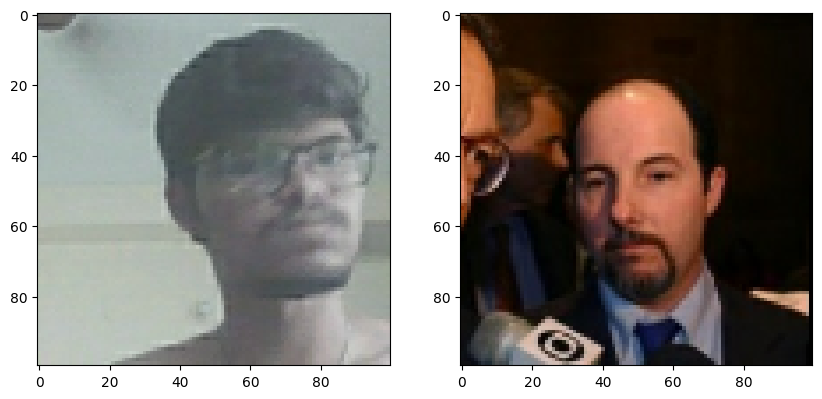

In [182]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[3])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[3])

# Renders cleanly
plt.show()

# 7. Save Model

In [183]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [184]:
L1Dist

__main__.L1Dist

In [185]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [186]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step


array([[9.9744421e-01],
       [2.4595912e-09],
       [9.9888331e-01],
       [5.2531574e-10],
       [9.4344527e-01],
       [9.9325311e-01],
       [4.7459414e-10],
       [5.3446220e-10],
       [4.7514576e-10],
       [3.5483427e-09],
       [9.9986666e-01],
       [3.4530934e-09],
       [1.2074287e-09],
       [9.8363024e-01],
       [7.8192736e-10],
       [9.5269388e-01]], dtype=float32)

In [187]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ functional (Functional)       │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_11 (L1Dist)           │ (None, 4096)              │               0 │ functional[0][0],          │
│                               │                           │                 │ functional[1][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_11[0][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 8. Real Time Test

## 8.1 Verification Function

In [ ]:
application_data\verification_images

In [189]:
os.listdir(os.path.join('application_data', 'verification_images'))

['2a28ec09-09f9-11f0-89ba-60f26206a526.jpg',
 '3c50a573-09fa-11f0-82f0-60f26206a526.jpg',
 '3c8a7cee-09fa-11f0-a55d-60f26206a526.jpg',
 '3ca234a8-09fa-11f0-830b-60f26206a526.jpg',
 '3cb68c7c-09fa-11f0-98e8-60f26206a526.jpg',
 '3cfd4b3d-09fa-11f0-a4c2-60f26206a526.jpg',
 '3cfd4b3e-09fa-11f0-bc2f-60f26206a526.jpg',
 '3d14a9bb-09fa-11f0-89b0-60f26206a526.jpg',
 '3d14a9bc-09fa-11f0-96ca-60f26206a526.jpg',
 '3d14a9bd-09fa-11f0-b77b-60f26206a526.jpg',
 '3e6abb9e-09fa-11f0-8362-60f26206a526.jpg',
 '3ead78e6-09fa-11f0-927c-60f26206a526.jpg',
 '3f3eb481-09fa-11f0-9720-60f26206a526.jpg',
 '3f3f4cea-09fa-11f0-bfe2-60f26206a526.jpg',
 '3f577896-09fa-11f0-be5d-60f26206a526.jpg',
 '3f87f9ec-09fa-11f0-9578-60f26206a526.jpg',
 '3fb7f8b8-09fa-11f0-a2c0-60f26206a526.jpg',
 '3fd0f777-09fa-11f0-bbad-60f26206a526.jpg',
 '3fed333f-09fa-11f0-9420-60f26206a526.jpg',
 '3fedd0a3-09fa-11f0-a097-60f26206a526.jpg',
 '4a3d8b45-09fa-11f0-855e-60f26206a526.jpg',
 '4a69c233-09fa-11f0-af27-60f26206a526.jpg',
 '4adb3d80

In [188]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [205]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\3c50a573-09fa-11f0-82f0-60f26206a526.jpg
application_data\verification_images\3cb68c7c-09fa-11f0-98e8-60f26206a526.jpg
application_data\verification_images\3d14a9bd-09fa-11f0-b77b-60f26206a526.jpg
application_data\verification_images\3f3eb481-09fa-11f0-9720-60f26206a526.jpg
application_data\verification_images\3fb7f8b8-09fa-11f0-a2c0-60f26206a526.jpg
application_data\verification_images\3fd0f777-09fa-11f0-bbad-60f26206a526.jpg
application_data\verification_images\3fed333f-09fa-11f0-9420-60f26206a526.jpg
application_data\verification_images\3fedd0a3-09fa-11f0-a097-60f26206a526.jpg
application_data\verification_images\40131d08-09fa-11f0-b940-60f26206a526.jpg
application_data\verification_images\4072d44b-09fa-11f0-9499-60f26206a526.jpg
application_data\verification_images\4073decc-09fa-11f0-89f3-60f26206a526.jpg
application_data\verification_images\408906fb-09fa-11f0-8222-60f26206a526.jpg
application_data\verification_images\408906fc-09fa-11f0-b938-60f

In [206]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [197]:
import os
import tensorflow as tf
import numpy as np
import cv2

# Suppress TensorFlow logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress INFO and WARNING logs
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

# Disable progress bars from TensorFlow
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions with verbose=0
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)), verbose=0)
        results.append(result)
    
    # Detection Threshold: Metric above which a prediction is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified


## 8.2 OpenCV Real Time Verification

In [195]:
# Suppress TensorFlow progress bars and logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TF logs (1=INFO, 2=WARNING, 3=ERROR)
tf.get_logger().setLevel('ERROR')  # Suppress additional TF logs


In [203]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [200]:
np.sum(np.squeeze(results) > 0.9)

np.int64(29)

In [201]:
results

[array([[0.99739915]], dtype=float32),
 array([[0.9996595]], dtype=float32),
 array([[0.9989448]], dtype=float32),
 array([[0.9729349]], dtype=float32),
 array([[0.9996746]], dtype=float32),
 array([[0.9997063]], dtype=float32),
 array([[0.99302423]], dtype=float32),
 array([[0.99958116]], dtype=float32),
 array([[0.9997525]], dtype=float32),
 array([[0.7371942]], dtype=float32),
 array([[0.9160207]], dtype=float32),
 array([[0.99885225]], dtype=float32),
 array([[0.85714054]], dtype=float32),
 array([[0.99859726]], dtype=float32),
 array([[0.9358964]], dtype=float32),
 array([[0.9883564]], dtype=float32),
 array([[0.9990359]], dtype=float32),
 array([[0.99612063]], dtype=float32),
 array([[0.9869862]], dtype=float32),
 array([[0.9990174]], dtype=float32),
 array([[0.9991842]], dtype=float32),
 array([[0.9862015]], dtype=float32),
 array([[0.99085975]], dtype=float32),
 array([[0.99851596]], dtype=float32),
 array([[0.9650924]], dtype=float32),
 array([[0.999258]], dtype=float32),
 arr